<a href="https://colab.research.google.com/github/MdSaifulIslamSajol/GDdemo/blob/main/%F0%9F%92%8A_Diabetes_Prediction_with_DNN_(PyTorch)_%F0%9F%A9%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'diabetes-health-indicators-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1703281%2F2789260%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240409T155716Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc391096f064c4a6ac9c5843191792f87584b8984d2d46f1d39649fc35cc4823f81d3b9447ab0883e6648a0b40d888e7d41c6b41a9a9f952dbc1ebbee3df760b0c8c9d746b789bd75cc15ada2ff99dfa9f591d33600ecc62fdda63ac8cf7e58f3e632a990d26737d1a2f06a340c1b9aef8273231fd2bb746950b333b1773698f5783dc966d637f821acda7a71af5f01cc38e95034fe96a1d0466041edf11836080eb92f2f4cacaeefaa64f861a28bdf4dcf24e3275d41e737c89c01b478f2c85f07c4ffc68fab6b37f3a8572af55056fc42f1aef19d45702ecd9ff157356897b4ee688553fcb6656a314e4f2667ba4f99cbee4fc3ef096a66c500625d7124146d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6324278 bytes downloaded
Downloaded and uncompressed: diabetes-health-indicators-dataset
Data source import complete.


Let's predict Diabetes using ```'diabetes_binary_5050split_health_indicators_BRFSS2015.csv'``` file.**

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [3]:
# Set random seed and Use 'cuda' GPU

torch.manual_seed(0)

if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed_all(0)

else:
    device = 'cpu'

In [4]:
# Get Total Dataset
df_train = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [5]:
df_train.shape

(70692, 22)

In [6]:
df_train

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


In [7]:
df_train['Diabetes_binary'].value_counts()

Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

As I can see with ```df_train.head()``` and ```df_train.info()```, it would be better to convert the values into **int**.

In [9]:
df_train = df_train.astype(int)

# Data Preparation

## Dataset Split

Train set + Validation set + Test set

In [10]:
# Dataset split
X = df_train.drop('Diabetes_binary', axis=1)
y = df_train['Diabetes_binary']

In [11]:
y

0        0
1        0
2        0
3        0
4        0
        ..
70687    1
70688    1
70689    1
70690    1
70691    1
Name: Diabetes_binary, Length: 70692, dtype: int64

In [12]:
# Use 10 % of total data as Test set and the rest as (Train + Validation) set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)



## Scaling

In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
X_train.shape

(63622, 21)

## Convert into Tensor

In [15]:
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)

y_train = torch.LongTensor(y_train.values).to(device)
y_test = torch.LongTensor(y_test.values).to(device)

In [16]:
from torch.utils.data import DataLoader, TensorDataset

# Assuming X_train, X_test, y_train, y_test are already defined and moved to the correct device
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
# Define your batch size
batch_size = 32

# Create the DataLoader for training data
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Create the DataLoader for test data
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



# Model

In [17]:
# Hyperparameter
learning_rate = 1e-3
epochs = 5
drop_prob = 0.1

In [18]:
X_train.shape

torch.Size([63622, 21])

In [19]:
y_train.unique()

tensor([0, 1], device='cuda:0')

In [20]:
# Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(21, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc4(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc5(out)
        return out

### Transformers

In [21]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer
import torch

# Example using a BERT model; you would need to adapt this heavily for tabular data
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Adapt your data to fit the model's expected input format
# This step is highly dependent on your specific dataset and model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
input_dim = 21
class TabularTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, dim_feedforward=512, nhead=3, num_layers=3):
        super(TabularTransformer, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead,
                                                        dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(input_dim, num_classes)

    def forward(self, src):
        src = src.unsqueeze(1)
        src = src.permute(1, 0, 2)  # Transformer expects (S, N, E) shape
        encoded = self.transformer_encoder(src)
        encoded = encoded.mean(dim=0)  # Aggregate embeddings
        return self.classifier(encoded)

# Assuming X_train is your features and y_train is your labels
input_dim = X_train.shape[1]  # Feature dimension
num_classes = len(y_train.unique())  # Number of unique classes

# model = TabularTransformer(input_dim=input_dim, num_classes=num_classes)
model = TabularTransformer(input_dim=X_train.shape[1], num_classes=len(y_train.unique())).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [23]:
model

TabularTransformer(
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=21, out_features=21, bias=True)
    )
    (linear1): Linear(in_features=21, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=512, out_features=21, bias=True)
    (norm1): LayerNorm((21,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((21,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=21, out_features=21, bias=True)
        )
        (linear1): Linear(in_features=21, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (l

In [24]:
# model = Net().to(device)
model = model.to(device)

# Optimizer and Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [25]:
# Initialize lists to store metrics
total_loss_train, total_acc_train = [], []
total_loss_test, total_acc_test = [], []
epoch_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = outputs.argmax(dim=1)
        correct_train += (pred == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    total_loss_train.append(train_loss / total_train)
    total_acc_train.append(train_accuracy)

    # Validation phase
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            pred = outputs.argmax(dim=1)
            correct_test += (pred == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100. * correct_test / total_test
    total_loss_test.append(test_loss / total_test)
    total_acc_test.append(test_accuracy)
    epoch_list.append(epoch+1)

    # Print training/testing loss and accuracy for each epoch
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss / total_train:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss / total_test:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch: 1, Training Loss: 0.0174, Training Accuracy: 71.78%, Test Loss: 0.0166, Test Accuracy: 73.69%
Epoch: 2, Training Loss: 0.0167, Training Accuracy: 73.07%, Test Loss: 0.0163, Test Accuracy: 74.57%
Epoch: 3, Training Loss: 0.0166, Training Accuracy: 73.59%, Test Loss: 0.0164, Test Accuracy: 74.33%
Epoch: 4, Training Loss: 0.0164, Training Accuracy: 73.85%, Test Loss: 0.0160, Test Accuracy: 74.79%
Epoch: 5, Training Loss: 0.0163, Training Accuracy: 74.08%, Test Loss: 0.0161, Test Accuracy: 74.89%


# Train

Train with Validation

Let's visualize the Train loss and Validadtion loss.

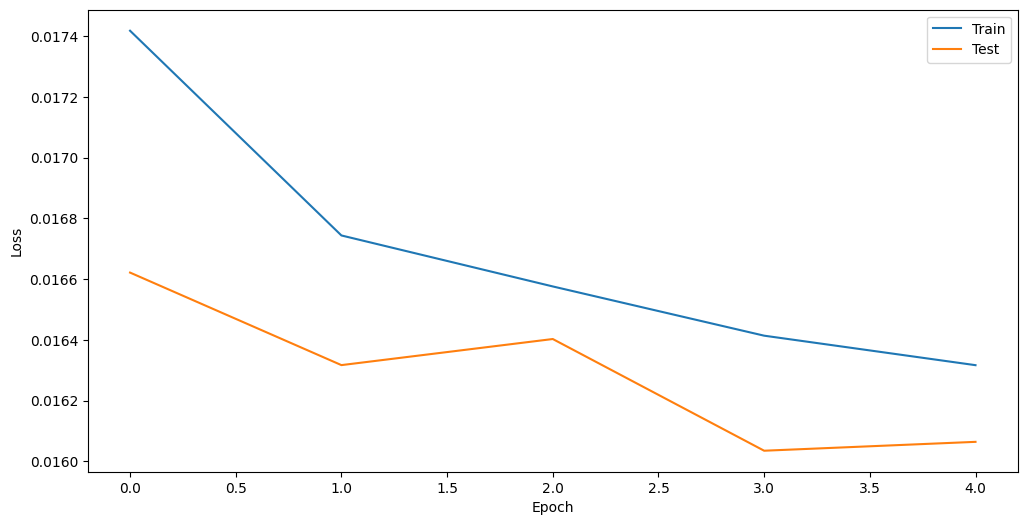

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(total_loss_train, label='Train')
plt.plot(total_loss_test, label='Test')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# import torch
# from transformers import BertTokenizer, BertForSequenceClassification
# from torch.utils.data import DataLoader, TensorDataset
# import numpy as np

# # Example: Tokenizing tabular data (very simplified and hypothetical)
# def tokenize_tabular_row(row, tokenizer):
#     # This is a placeholder function; you'll need to adapt it
#     # Convert row to a text string (e.g., "feature1 feature2 ...")
#     row_text = ' '.join(str(value) for value in row)
#     return tokenizer.encode_plus(row_text, padding='max_length', max_length=512, truncation=True, return_tensors="pt")

# # Initialize tokenizer and model
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# # Assume X_train is your tabular data and y_train are your labels
# inputs = torch.empty((len(X_train), 512))  # Assuming max_length=512
# attention_masks = torch.empty((len(X_train), 512))

# for i, row in enumerate(X_train):
#     encoded_dict = tokenize_tabular_row(row, tokenizer)
#     inputs[i] = encoded_dict['input_ids']
#     attention_masks[i] = encoded_dict['attention_mask']

# # Convert labels to tensors
# labels = torch.tensor(y_train)

# # Create a DataLoader
# dataset = TensorDataset(inputs, attention_masks, labels)
# dataloader = DataLoader(dataset, batch_size=32)

# # Example training loop (simplified)
# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# for epoch in range(4):  # Loop over epochs
#     for batch in dataloader:
#         b_input_ids, b_input_mask, b_labels = batch
#         model.zero_grad()
#         outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

Validation loss is lower than Train loss because of 'Dropout' layer.

# Predict Test set

Use the whole train set(Train + Validation above).

### Please **Upvote** if you like my notebook!
### Thank you!